# Team1 유니콘 기업 발굴 결과
# 5개의 기업 : 294337 / 127366 / 469677 / 403470 / 440094

# 목표: 원티드 국민연금DB를 이용해서 유니콘 기업 발굴하기


## **EDA 목표**

- 유니콘 기업을 발굴하고 
- 데이터들의 분포(직원수, 매출액, 보험료, +@)
- 몇몇 회사를 선택하여 데이터 흐름 살펴보기
- 데이터 사이의 관계에 대해 유의미한 결론을 찾아봅시다.

# 개요
1. 데이터 탐구 
2. Team1만의 유니콘 기업 발굴 기준
3. 데이터 EDA
4. 실제 유니콘기업 데이터 확인
5. 유니콘기업과 비슷한 데이터 추출
6. 유니콘기업 기준 적용
7. 유니콘 기업 발굴
8. 데이터 살펴보기

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import re

import plotly.express as px
import plotly

import sys
import warnings
warnings.filterwarnings('ignore')

from selenium import webdriver
from selenium.webdriver.common.keys import Keys # 엔터키 입력용
import pandas as pd
import time

In [5]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야함.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨짐.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

In [6]:
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당.
a = get_font_family()
# 폰트설정
plt.rc("font", family = a)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# ggplot으로 그래프 스타일 설정
#plt.style.use("ggplot")

# 데이터 불러오기
df = pd.read_csv('company_nps_data.csv', encoding='cp949')

# 데이터 탐구

In [43]:
# 데이터 형태 확인
df.shape

(99801, 6)

In [44]:
df.info() #모든 데이터 값은 int64타입.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   회사ID      99801 non-null  int64
 1   연매출액      99801 non-null  int64
 2   년도        99801 non-null  int64
 3   월         99801 non-null  int64
 4   월별_연금보험료  99801 non-null  int64
 5   월별_직원수    99801 non-null  int64
dtypes: int64(6)
memory usage: 4.6 MB


In [45]:
# 시계열데이터 생성
df['년월'] = pd.to_datetime(df['년도'].astype(str) + df['월'].astype(str), format='%Y%m').dt.strftime('%Y%m')

In [46]:
# 컬럼별 유니크 값 출력 ==> 특이점 없음
for col in df.columns:
    print(f"column : {col}")
    print(f"The number of unique : {df[col].nunique()}")
    print()

column : 회사ID
The number of unique : 5000

column : 연매출액
The number of unique : 10108

column : 년도
The number of unique : 5

column : 월
The number of unique : 12

column : 월별_연금보험료
The number of unique : 50747

column : 월별_직원수
The number of unique : 1187

column : 년월
The number of unique : 50



### Null값 확인

In [47]:
df.isnull().sum() #우선 nan로 표시된 결측값은 없다.

회사ID        0
연매출액        0
년도          0
월           0
월별_연금보험료    0
월별_직원수      0
년월          0
dtype: int64

### 이상치 확인

In [48]:
df.describe() #이상치 확인

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
count,9.980100e+04,9.980100e+04,99801.000000,99801.000000,9.980100e+04,99801.000000
mean,2.762982e+05,3.053589e+07,2016.967125,6.714352,9.734079e+06,37.623431
std,1.339032e+05,3.016647e+08,0.976688,3.512966,4.347256e+07,146.947194
min,6.300000e+01,-7.882176e+06,2015.000000,1.000000,0.000000e+00,0.000000
25%,1.655300e+05,1.409760e+06,2016.000000,4.000000,1.181160e+06,6.000000
50%,2.591490e+05,3.573585e+06,2017.000000,7.000000,2.332760e+06,11.000000
75%,3.826560e+05,9.582321e+06,2018.000000,10.000000,5.591860e+06,24.000000
max,5.159723e+06,1.132878e+10,2019.000000,12.000000,9.780673e+08,3133.000000


## 열 상관계수 확인

In [49]:
# 필요없는 columns 삭제
df.drop(df[['회사ID','년도','월','년월']], axis=1, inplace=True)

# Z-score 표준화
for col in df.columns :
    series_mean = df[col].mean()
    series_std = df[col].std() 
    df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)

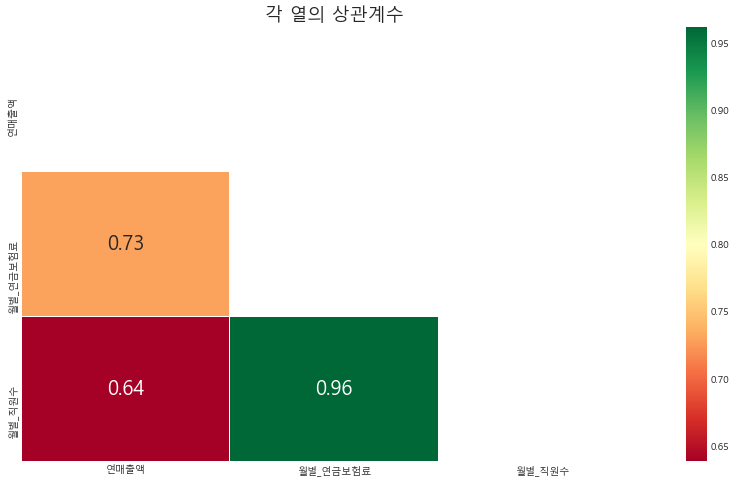

In [12]:
corr = df.corr()
corr
mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14, 8))
plt.title('각 열의 상관계수', fontsize=18)
sns.heatmap(corr, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

## 매출 100위 전체 데이터 시각화

In [ ]:
df = pd.read_csv('company_nps_data.csv', encoding='cp949')

In [12]:
df_전체매출시각화 =df.loc[:, ["년도",'회사ID','연매출액']]
df_전체매출시각화 = df_전체매출시각화.drop_duplicates('연매출액')
df_전체매출시각화 = df_전체매출시각화 .sort_values(by='연매출액' ,ascending=False)
top_100_2015 = df_전체매출시각화.loc[df_전체매출시각화["년도"] == 2015].sort_values(by='연매출액' ,ascending=False)[:100]

In [13]:
top_100_2015 = df_전체매출시각화.loc[df_전체매출시각화["년도"] == 2015].sort_values(by='연매출액' ,ascending=False)[:100]
top_100_2016 = df_전체매출시각화.loc[df_전체매출시각화["년도"] == 2016].sort_values(by='연매출액' ,ascending=False)[:100]
top_100_2017 = df_전체매출시각화.loc[df_전체매출시각화["년도"] == 2017].sort_values(by='연매출액' ,ascending=False)[:100]
top_100_2018 = df_전체매출시각화.loc[df_전체매출시각화["년도"] == 2018].sort_values(by='연매출액' ,ascending=False)[:100]
top_100_2019 = df_전체매출시각화.loc[df_전체매출시각화["년도"] == 2019].sort_values(by='연매출액' ,ascending=False)[:100]
top_100_concat = pd.concat([top_100_2015,top_100_2016,top_100_2017,top_100_2018,top_100_2019])

In [1]:
fig3 = px.line(top_100_concat, 
              x='년도', 
              y='연매출액',
              color="회사ID"
              )
fig3

![newplot](./newplot.png)

In [15]:
top_100_concat.pivot(index='년도', columns='회사ID', values='연매출액')

회사ID,63,95,102,295,597,2037,2842,5202,5452,8208,...,547586,567650,570867,580356,581504,620445,630190,2693684,3312354,5159723
년도,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,1.132878e+10,656947437.0,742658938.0,83776697.0,208141595.0,NaN,113877008.0,90027705.0,252376511.0,NaN,...,283610660.0,113663897.0,NaN,278460000.0,NaN,NaN,657402850.0,NaN,NaN,NaN
2019,NaN,NaN,NaN,NaN,NaN,16308882.0,NaN,NaN,NaN,4151961.0,...,NaN,NaN,1500.0,NaN,1079693.0,767324.0,NaN,238076.0,1451563.0,2591898.0


# 유니콘 기업 정의
**[유니콘 기업(Unicorn)은 기업 가치가 10억 달러(=1조 원) 이상이고 창업한 지 10년 이하인 비상장 스타트업 기업을 말한다.](https://ko.wikipedia.org/wiki/%EC%9C%A0%EB%8B%88%EC%BD%98_%EA%B8%B0%EC%97%85)**  

## 매출액 Top 10 스타트업

[캐치가 선정한 매출액 Top10 스타트업](https://m.catch.co.kr/Comp/CompThemeRank?TCode=163)
- 우아한 형제들
    - 매출액 : 1625억
    - 직원수 : 1050명(2020)
    
- 쏘카 
    - 매출액 : 1210억
    - 직원수 : 330명(2020)
    
- 네시삼십삼분
    - 매출액 : 722억 
    - 직원수 : 133명
    
- 딜리버리히어로코리아
    - 매출액 : 671억
    - 직원수 : 800명(2019)
    
- 리디 
    - 매출액 : 665억
    - 직원수 : 137명(2018)
    
- 야놀자
    - 매출액 : 545억
    - 직원수 : 1000명(2019)

- 블랭크코퍼레이션
    - 매출액 : 478억
    - 직원수 : 205명(2020)

- 레진엔터테인먼트
    - 매출액 : 448억
    - 직원수 : 143명(2019)

- 미미박스
    - 매출액 : 440억
    - 직원수 : 98명

- 뱅크웨어글로벌
    - 매출액 : 388억
    - 직원수 : 285명(2016)    

# 유니콘기업 최소 기준

## 매출: 400억 이상
## 직원 수: 100명 이상

1. 매출액에 기반한 분석 ✔
    - 일정 금액 이상의 데이터만 남긴다 (매출액 최소 400억 이상)


2. 직원수에 기반한 분석 ✔
    - 일정 직원 수 이상의 데이터만 남긴다. (최소 100명 이상)

# 데이터 EDA
## 요약

1. 데이터 내 직원수가 0명인 회사를 제거한다.
2. 데이터 개수가 24개 이하인 회사를 제거한다. (업력 2년 이상)
3. 연매출액 400억 이하인 회사ID를 제거한다. (캐치 참고)
4. 직원수가 100명 이하인 회사ID를 제거한다. (캐치 참고)
5. 연매출액_변화량, 월별_직원수_변화량 컬럼을 생성한다.
6. 연매출액 유지 및 증가한 회사 ID만을 추출한다.
7. 직원수 유지 및 증가한 회사 ID만 추출한다.
8. 시각화 진행한다.



In [13]:
# 위에서 스케일링 등 컬럼값이 변화했기 때문에 다시 데이터프레임 read
# 데이터 불러오기
df = pd.read_csv("./company_nps_data.csv", encoding="cp949")

In [14]:
# 연도와 월을 묶어서 컬럼 형성
df['년월'] = pd.to_datetime(df['년도'].astype(str) + df['월'].astype(str), format='%Y%m').dt.strftime('%Y%m')

# 회사ID, 연도와 월을 제거해보자
df.drop(df[['년도','월']], axis=1, inplace=True)

# 시간순으로 나열해보자
df= df.sort_values(by='년월')

In [15]:
# 전체 파일 길이 
print("데이터 길이 :", len(df))

데이터 길이 : 99801


In [16]:
# 송재환님 코드 참고 : https://github.com/chsop/team4_wanted_onboarding/blob/main/Jaehwan_onboarding_week1_EDA_v0.1.ipynb
# 월별 연금 보험료와 월별 직원수가 0인 경우 제외 처리
df = df.drop(index=df.query('월별_직원수 == 0').index)
print(df.shape)

(99788, 5)


In [17]:
# 데이터가 일정 개수 이상 존재하는 회사만 남긴다.
length_df = df.groupby("회사ID").filter(lambda x : len(x) > 24) # 업력이 2년 이상 ==> 모든 데이터가 연속인가?
print(length_df.shape)

(55358, 5)


In [18]:
# 연매출액 400억 이상인 회사만 남긴다.
sales_df = length_df[length_df["연매출액"]>40000000]
print(sales_df.shape)

(6120, 5)


In [19]:
# 직원수가 100명 이상인 회사만 남긴다.
worker_df = sales_df[sales_df["월별_직원수"]>=100]
print(worker_df.shape)

(3080, 5)


In [20]:
# 연매출액과 직원수 변화량 컬럼을 만든다.

list_id = worker_df['회사ID'].unique()
check_df = pd.DataFrame(columns= ['회사ID','연매출액','월별_연금보험료','월별_직원수','년월','연매출액_변화량','월별_직원수_변화량'])

for x in list_id :  
    new_df = df[df['회사ID']==x]
    change_sales_columns = [0]
    change_worker_columns = [0]
    for i in range(len(new_df)-1) :
        new_sales = new_df.iloc[i+1][1] - new_df.iloc[i][1]
        change_sales_columns.append(new_sales)
        new_worker = new_df.iloc[i+1][3] - new_df.iloc[i][3]
        change_worker_columns.append(new_worker)    
    new_df['연매출액_변화량'] = change_sales_columns
    new_df['월별_직원수_변화량'] = change_worker_columns
    check_df = pd.concat([check_df, new_df])

In [21]:
# 연매출액 성장하지 못한 회사ID 제거
check_id_list = check_df['회사ID'].unique()
change_sales_list = []
for x in check_id_list :
    new_df = check_df[check_df['회사ID']==x]
    if sum(new_df['연매출액_변화량']) > 0 : # 매출액 마이너스 성장이 아닌 회사
        change_sales_list.append(x) 
print(len(change_sales_list), "개 회사의 매출액이 유지 및 증가했습니다.")
print(change_sales_list)

62 개의 회사의 매출액이 유지 및 증가했습니다.
[126814, 294387, 294337, 469473, 231080, 130023, 294367, 129436, 126538, 403504, 126674, 403462, 126802, 127503, 128638, 130281, 127366, 126664, 127065, 294620, 126983, 227414, 127090, 294530, 128264, 126606, 127511, 126831, 420082, 381180, 227415, 403359, 294649, 127669, 129370, 381344, 403434, 128440, 128539, 469677, 394723, 469458, 420046, 419945, 420165, 420304, 130386, 130344, 131049, 469567, 127142, 129310, 130387, 129718, 403470, 129861, 128076, 403657, 231260, 130899, 231090, 440094]


In [22]:
# 직원수가 증가하지 못한 회사ID 제거
change_worker_list = []
for z in change_sales_list :
    worker_df = check_df[check_df['회사ID']==z]
    if sum(worker_df['월별_직원수_변화량']) > 0 : # 직원수 마이너스 변화가 없는 회사
        change_worker_list.append(z)   
print(len(change_worker_list), "개 회사의 직원수가 유지 및 증가했습니다.")  
print(change_worker_list)

45 개의 회사의 직원수가 유지 및 증가했습니다.
[126814, 294387, 294337, 469473, 231080, 294367, 126538, 403504, 126802, 127503, 128638, 127366, 126664, 294620, 126983, 227414, 294530, 128264, 227415, 403359, 294649, 127669, 129370, 381344, 128440, 469677, 394723, 469458, 420046, 420165, 420304, 130386, 130344, 131049, 127142, 129310, 130387, 129718, 403470, 129861, 128076, 403657, 130899, 231090, 440094]


In [32]:
# 시각화 함수

def visualization(df,x) :
    new_name = df[df['회사ID']==x]
    print(x,"회사 그래프입니다.")
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.plot(new_name['년월'],new_name['연매출액'])
    plt.title("매출액", fontsize=25)
    plt.xticks(rotation='vertical')
    plt.subplot(222)
    plt.plot(new_name['년월'],new_name['월별_직원수'])
    plt.title("직원수", fontsize=25)
    plt.xticks(rotation='vertical')
    plt.show()
    print()
    print()

126814 회사 그래프입니다.


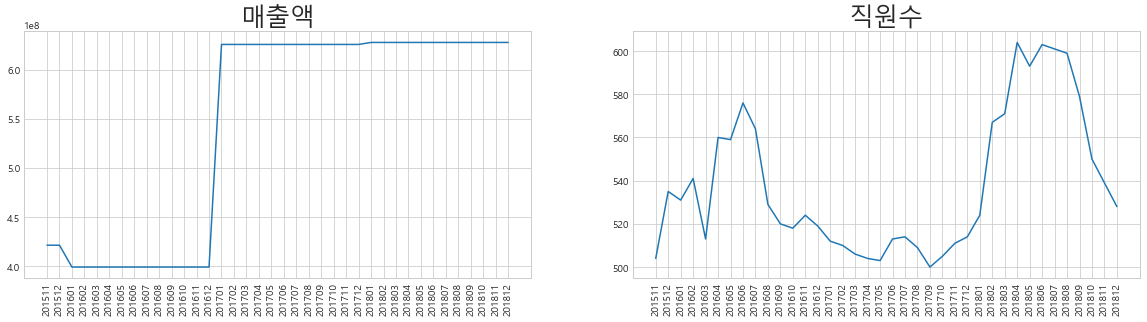



294387 회사 그래프입니다.


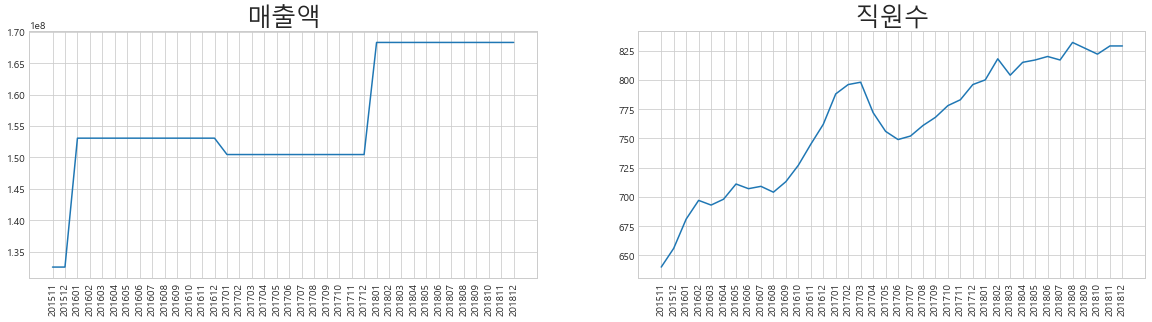



294337 회사 그래프입니다.


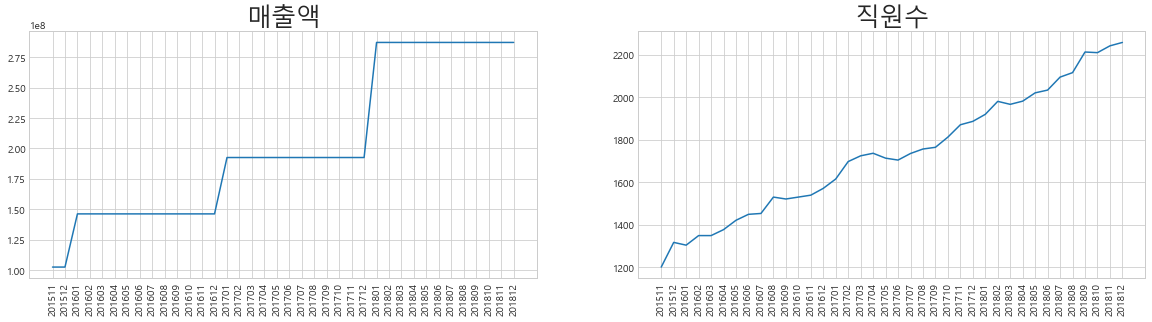



469473 회사 그래프입니다.


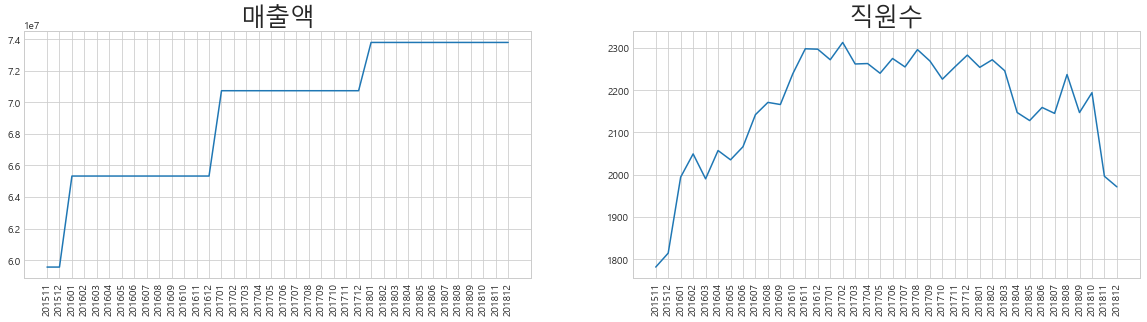



231080 회사 그래프입니다.


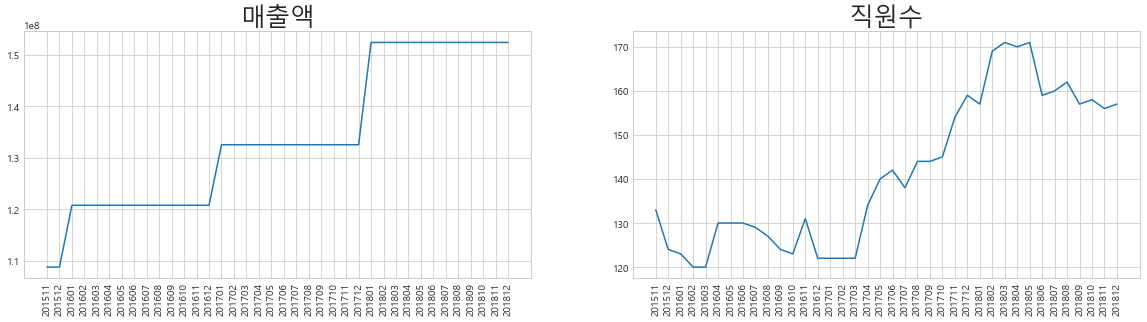



294367 회사 그래프입니다.


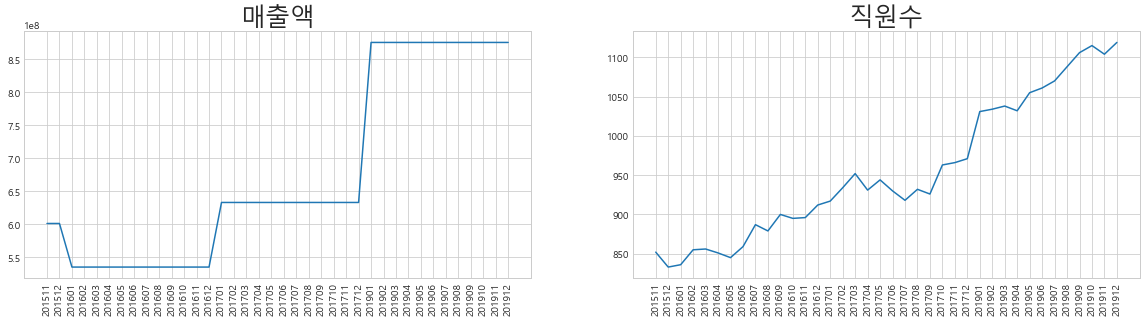



126538 회사 그래프입니다.


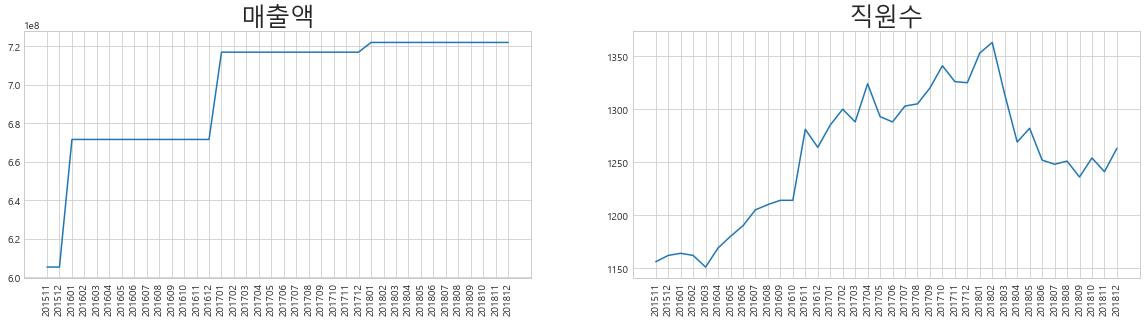



403504 회사 그래프입니다.


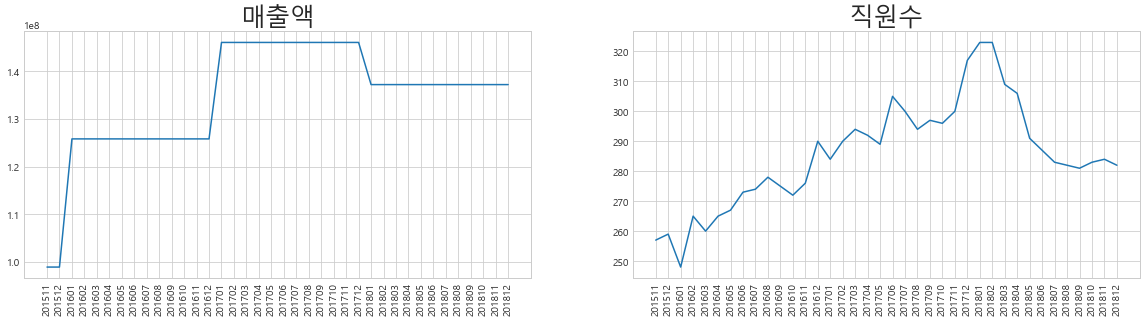



126802 회사 그래프입니다.


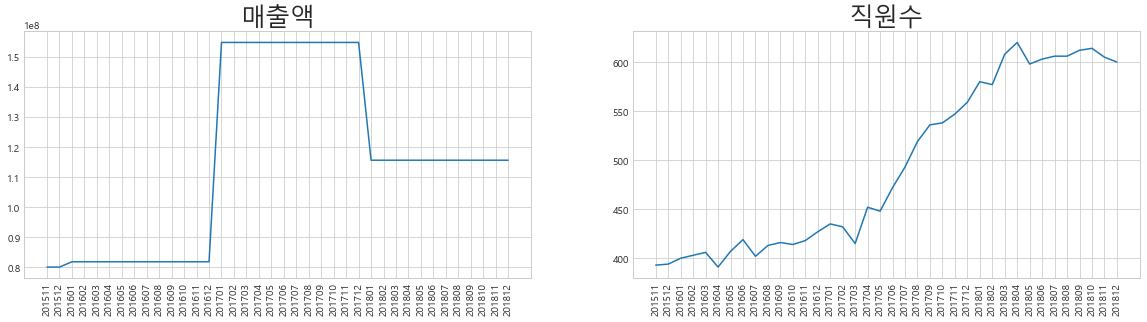



127503 회사 그래프입니다.


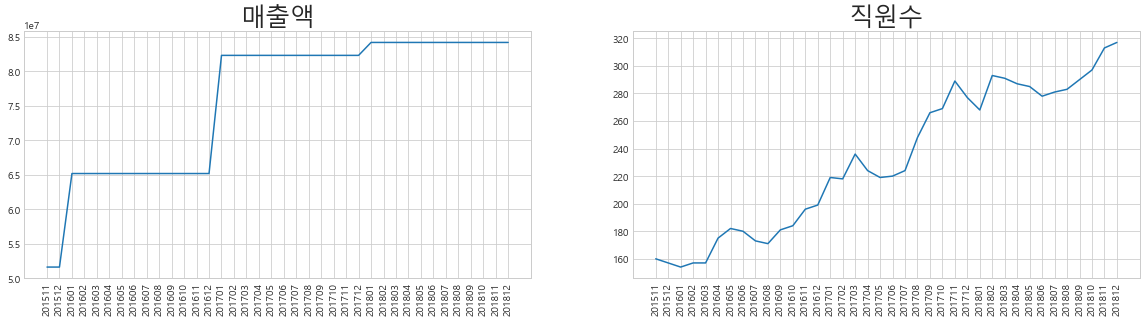



128638 회사 그래프입니다.


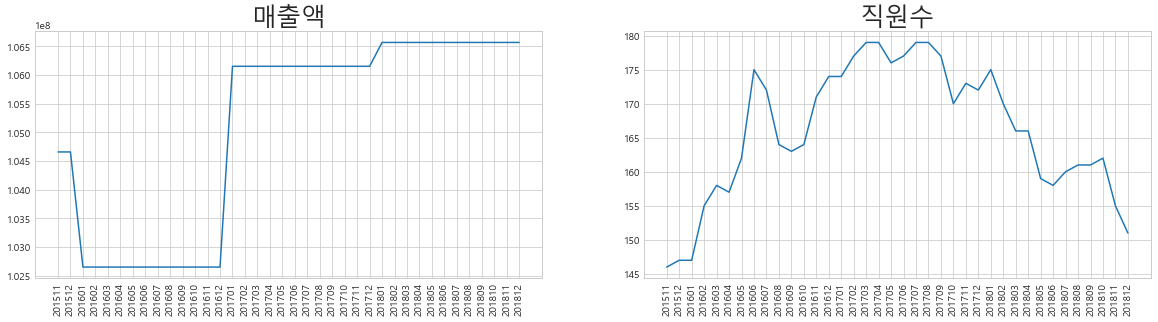



127366 회사 그래프입니다.


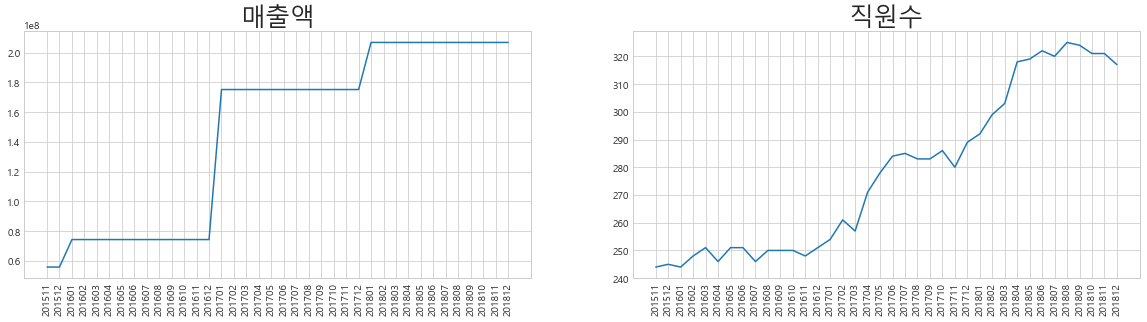



126664 회사 그래프입니다.


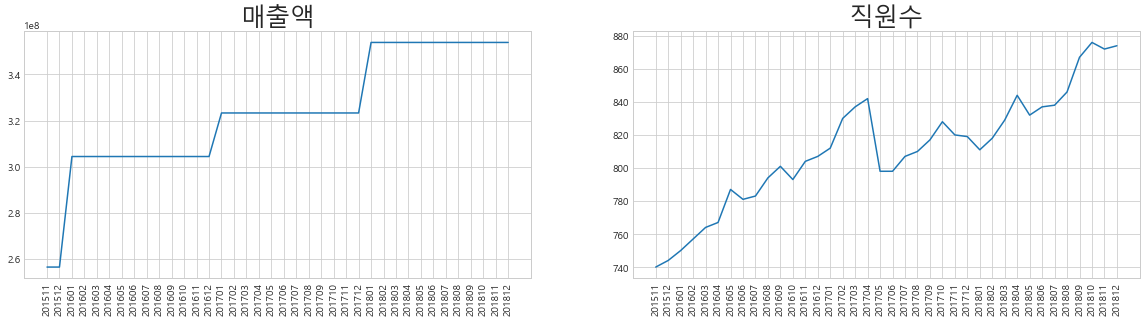



294620 회사 그래프입니다.


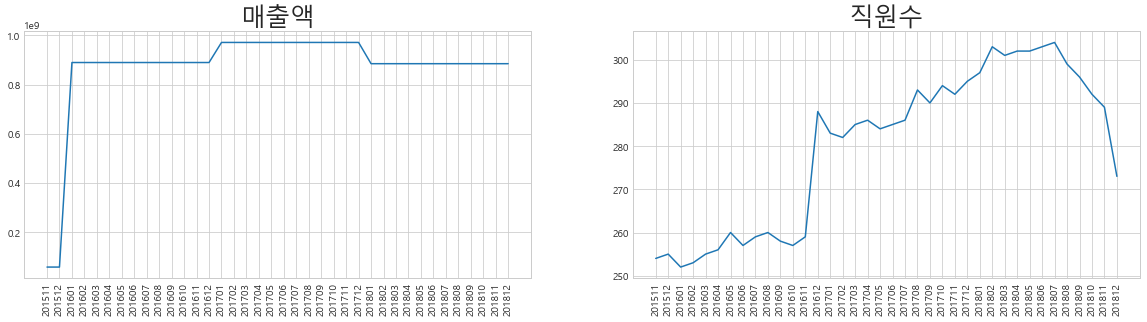



126983 회사 그래프입니다.


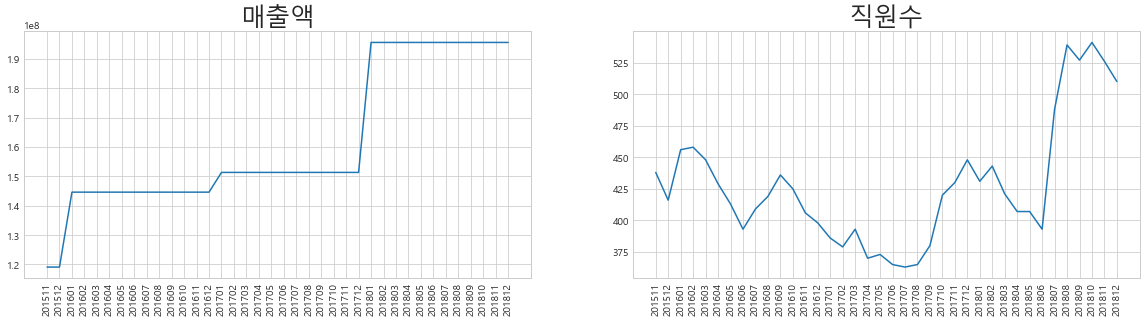



227414 회사 그래프입니다.


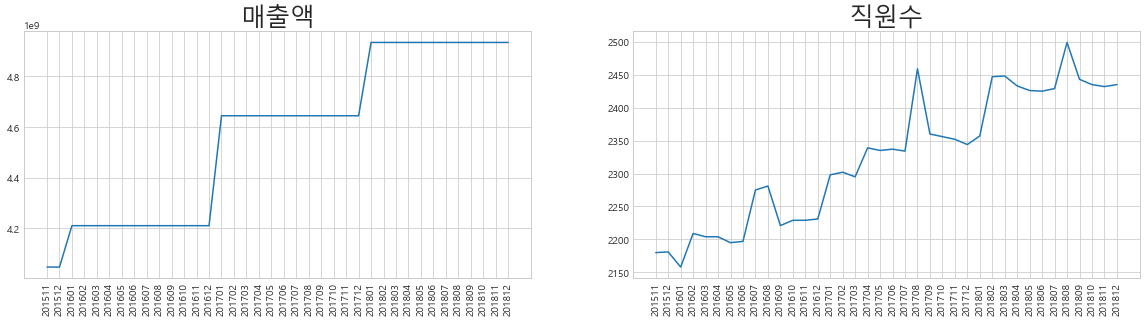



294530 회사 그래프입니다.


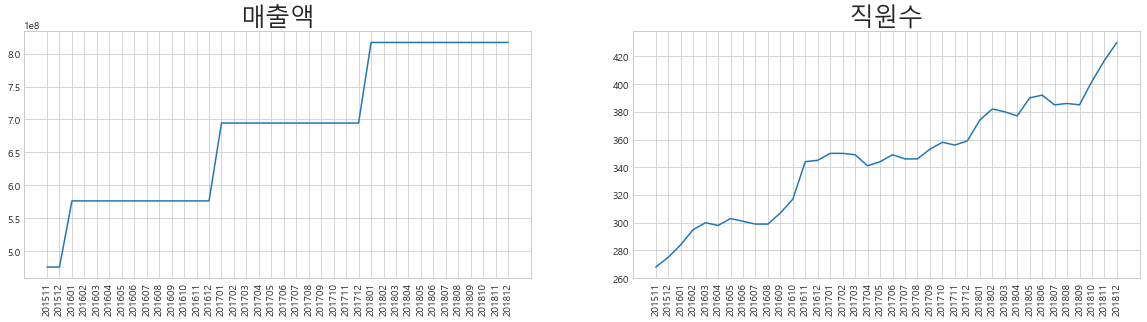



128264 회사 그래프입니다.


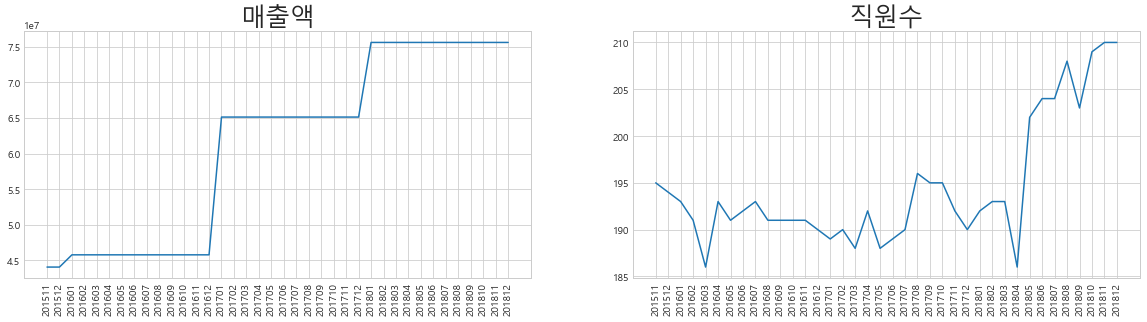



227415 회사 그래프입니다.


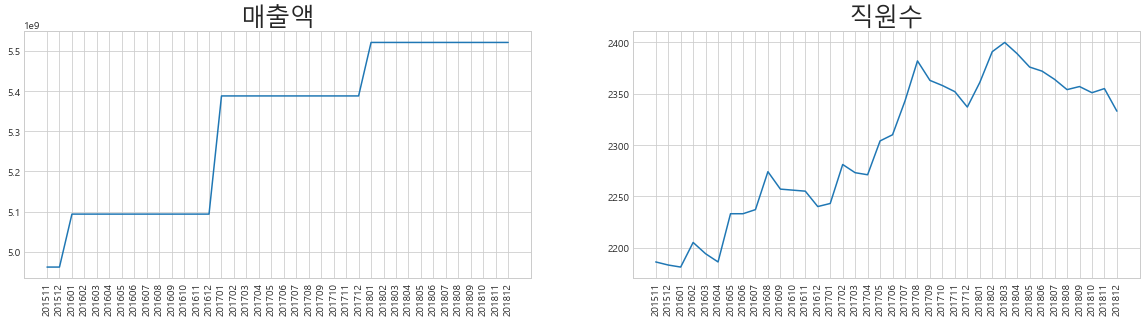



403359 회사 그래프입니다.


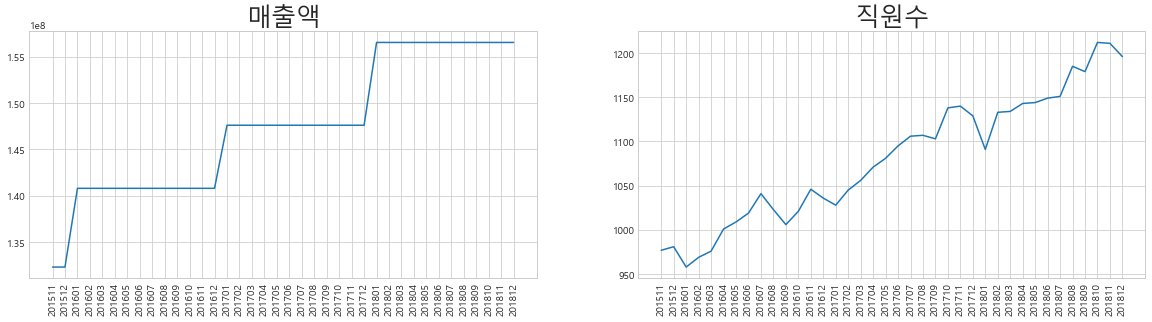



294649 회사 그래프입니다.


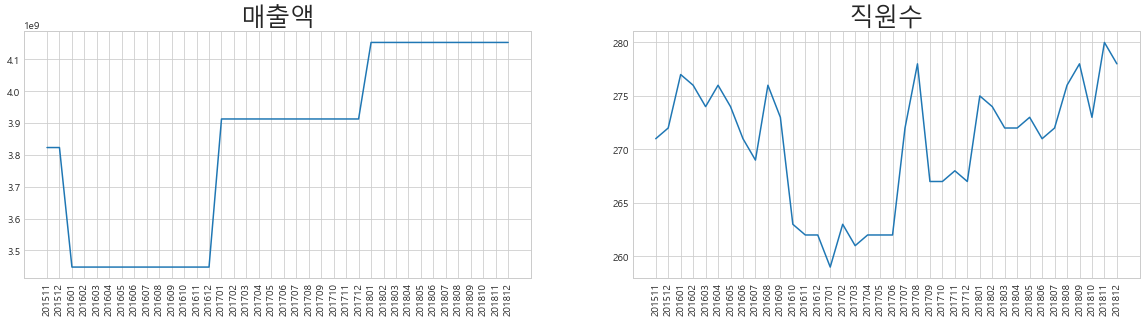



127669 회사 그래프입니다.


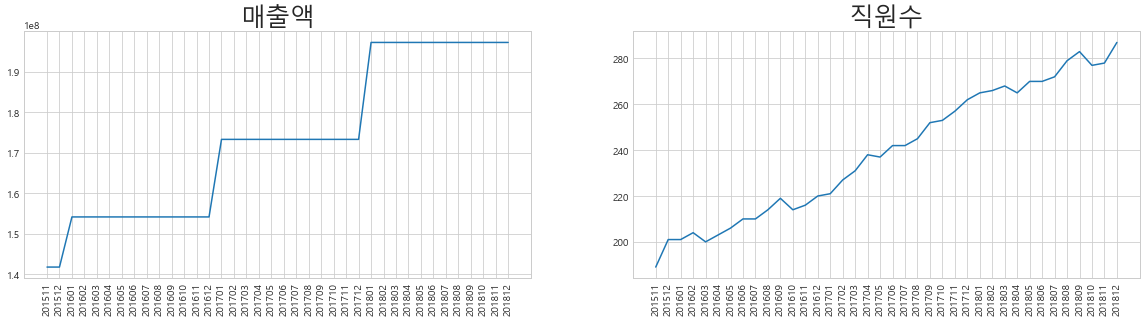



129370 회사 그래프입니다.


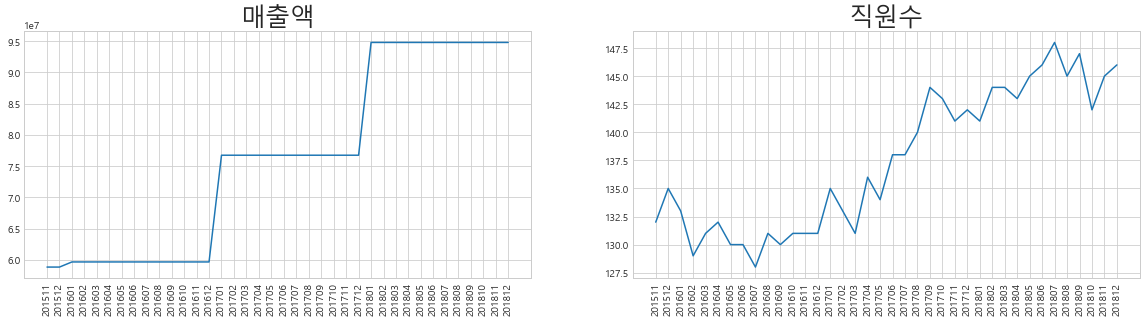



381344 회사 그래프입니다.


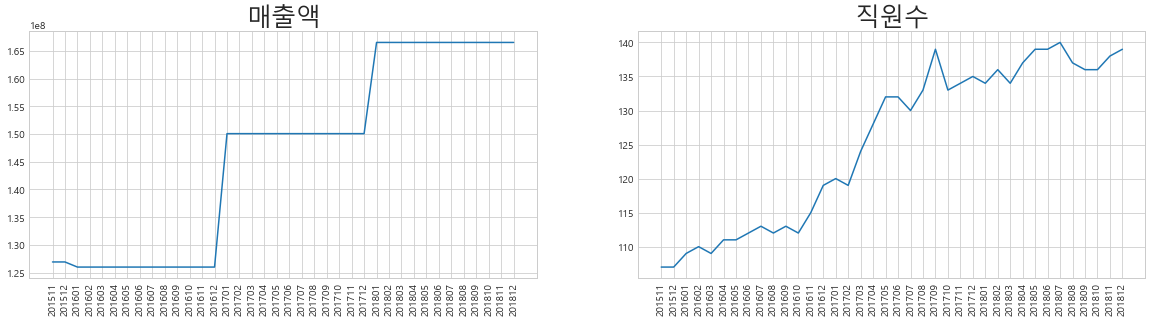



128440 회사 그래프입니다.


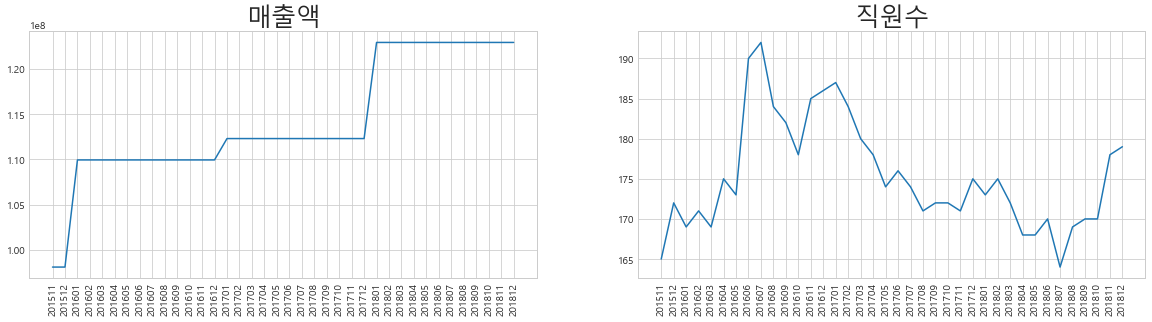



469677 회사 그래프입니다.


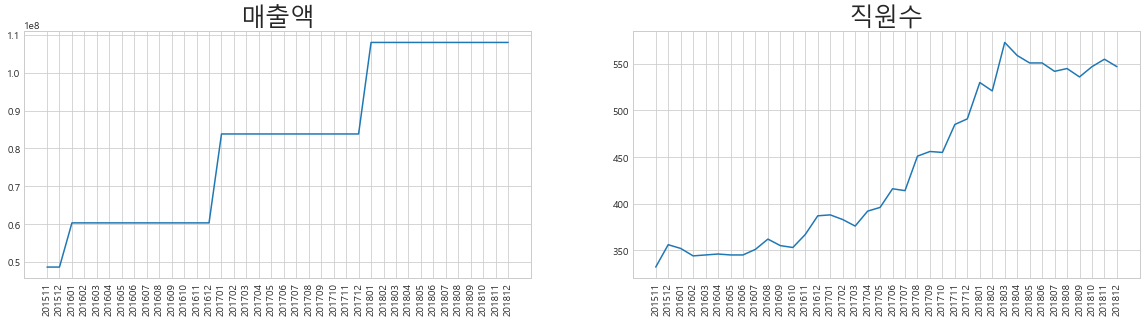



394723 회사 그래프입니다.


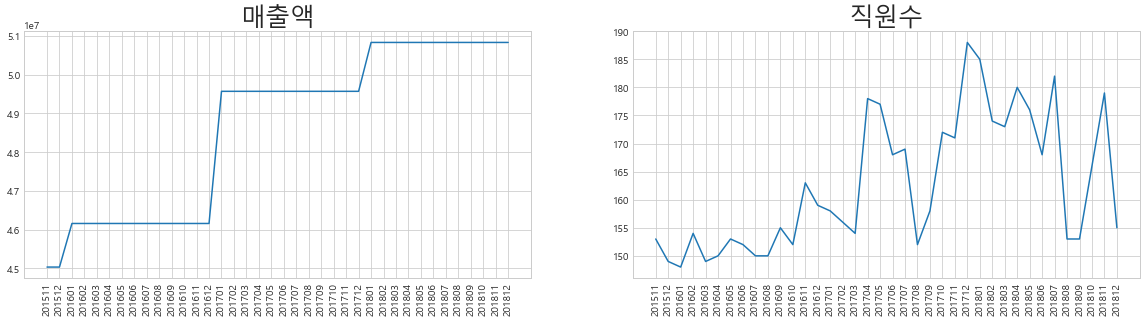



469458 회사 그래프입니다.


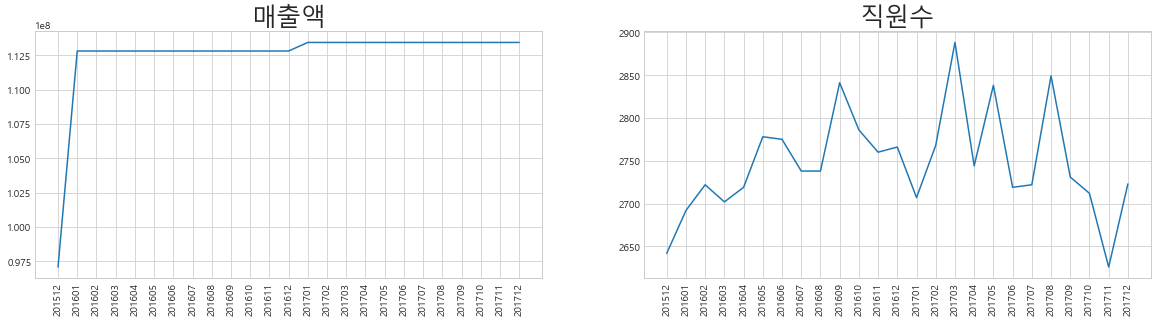



420046 회사 그래프입니다.


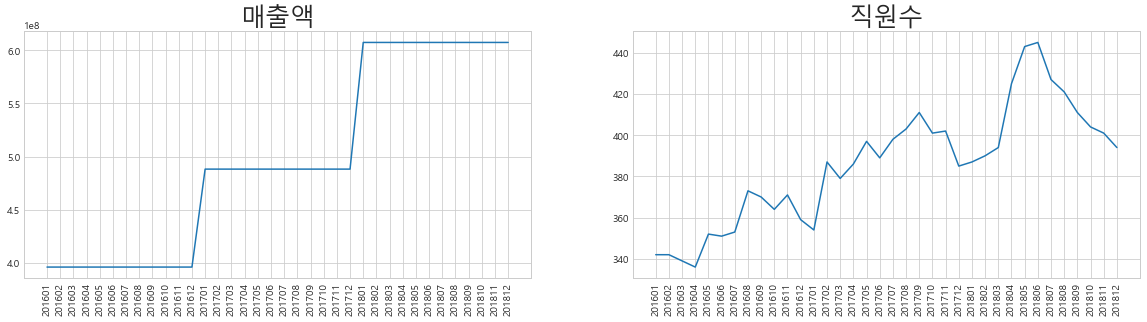



420165 회사 그래프입니다.


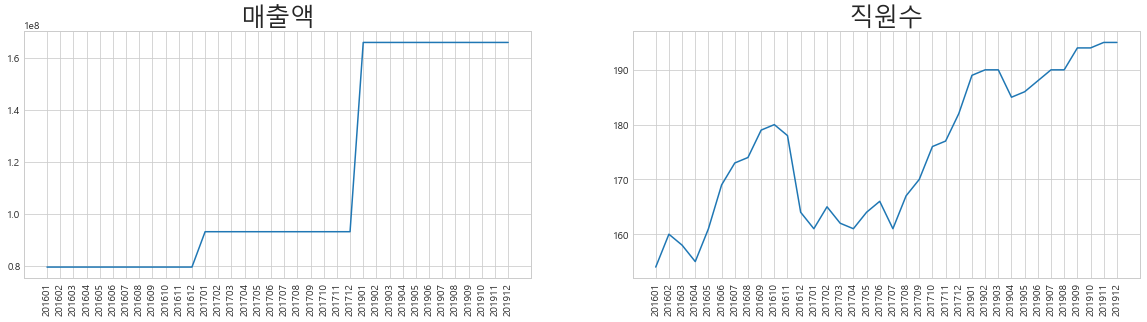



420304 회사 그래프입니다.


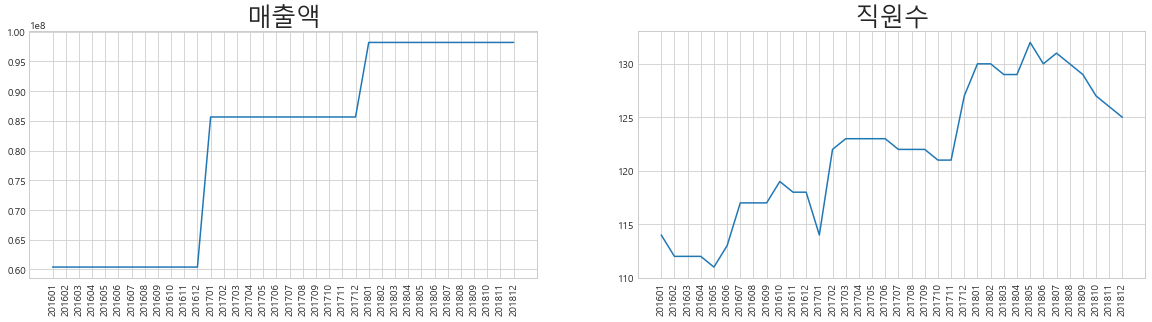



130386 회사 그래프입니다.


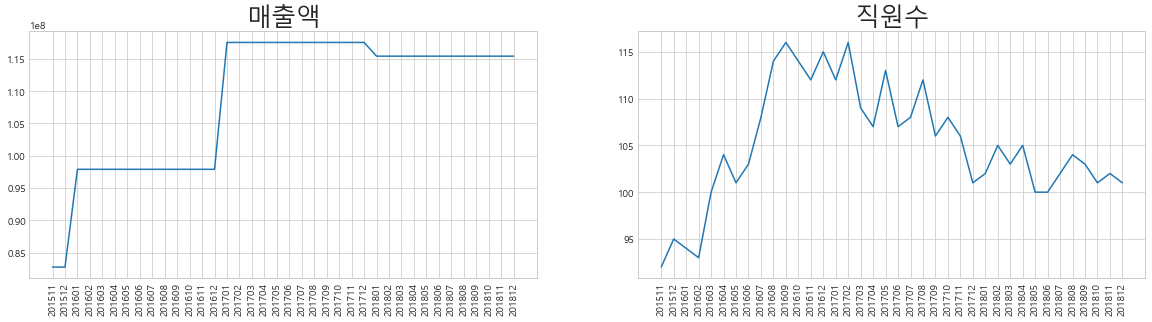



130344 회사 그래프입니다.


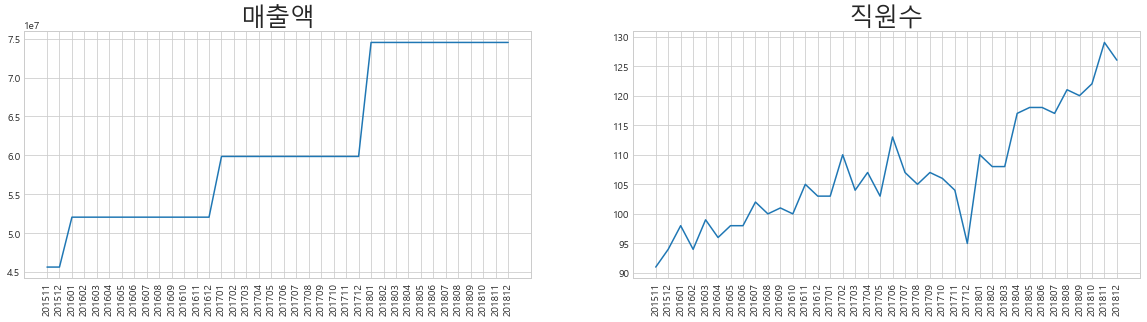



131049 회사 그래프입니다.


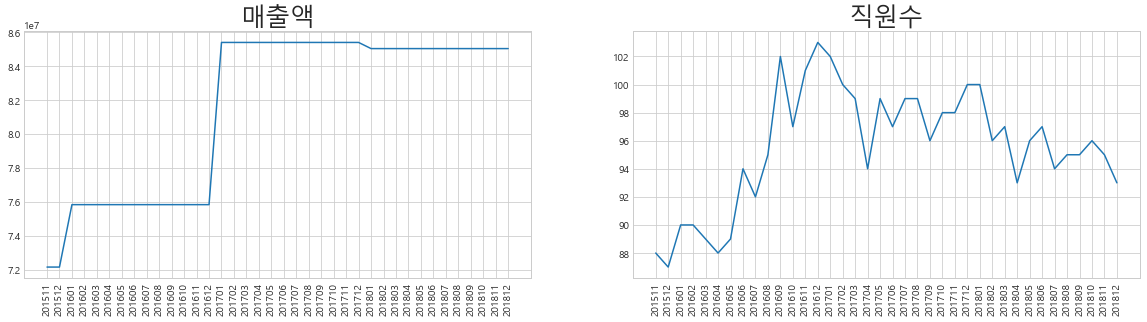



127142 회사 그래프입니다.


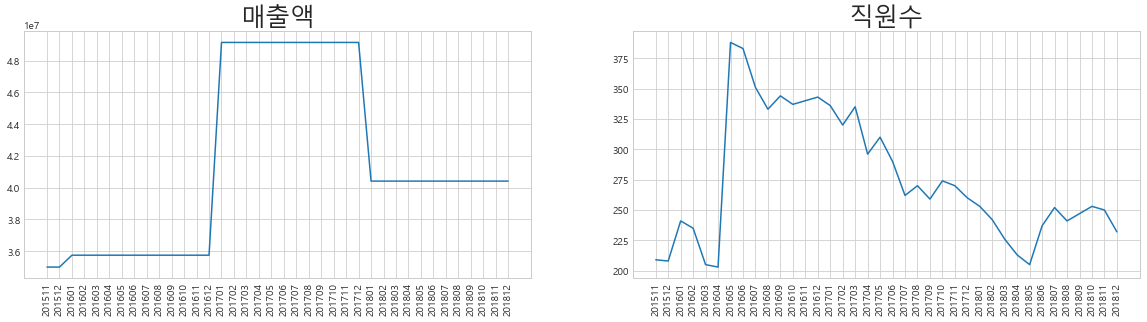



129310 회사 그래프입니다.


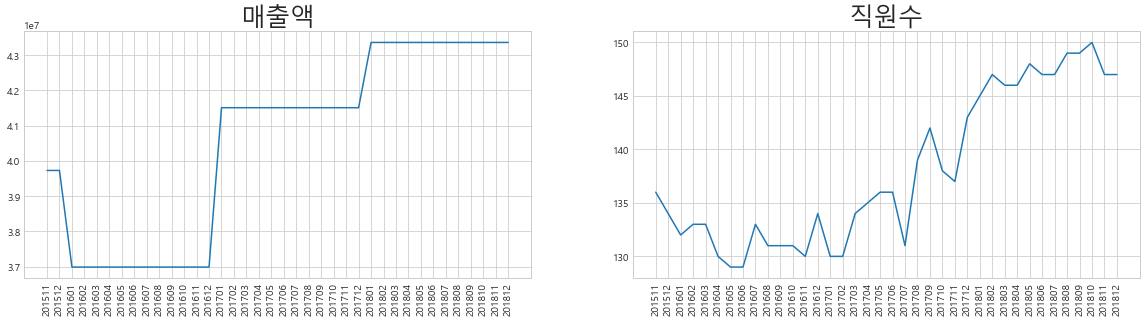



130387 회사 그래프입니다.


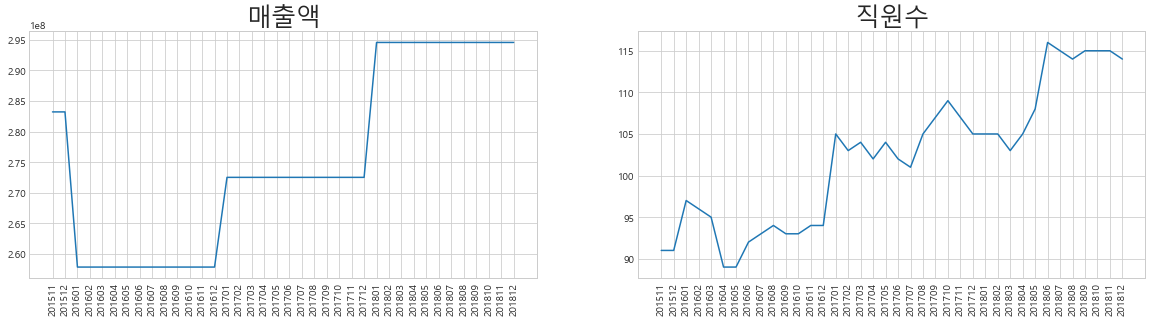



129718 회사 그래프입니다.


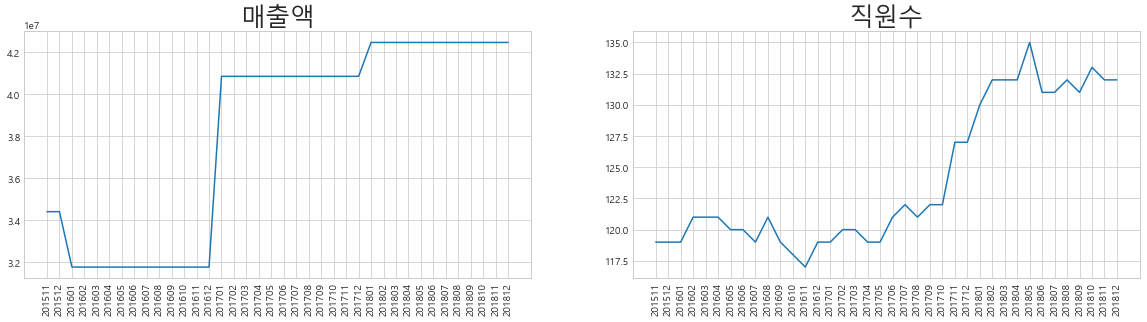



403470 회사 그래프입니다.


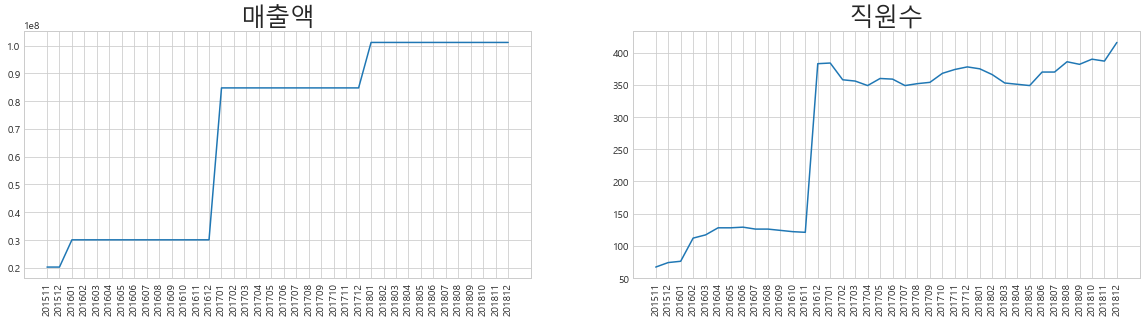



129861 회사 그래프입니다.


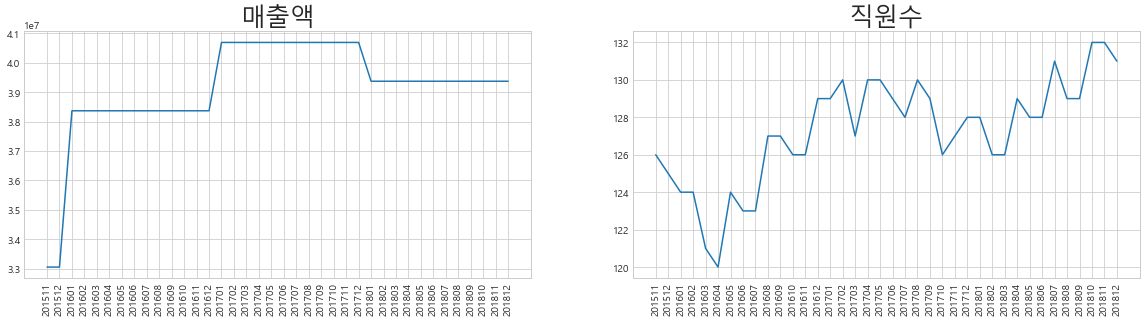



128076 회사 그래프입니다.


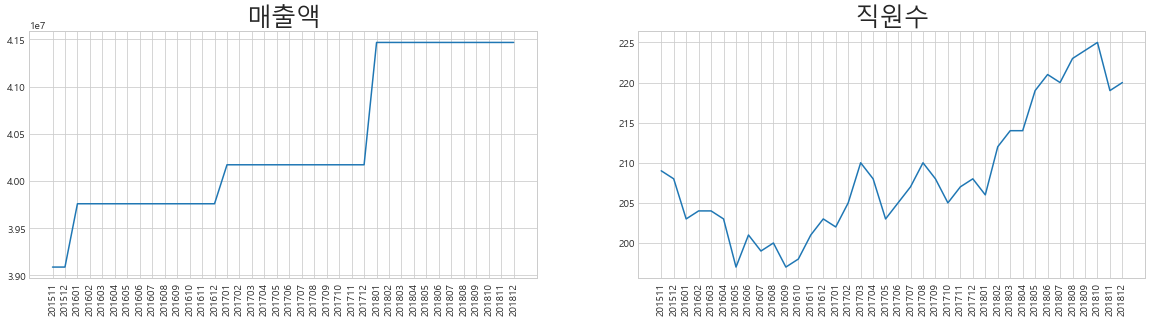



403657 회사 그래프입니다.


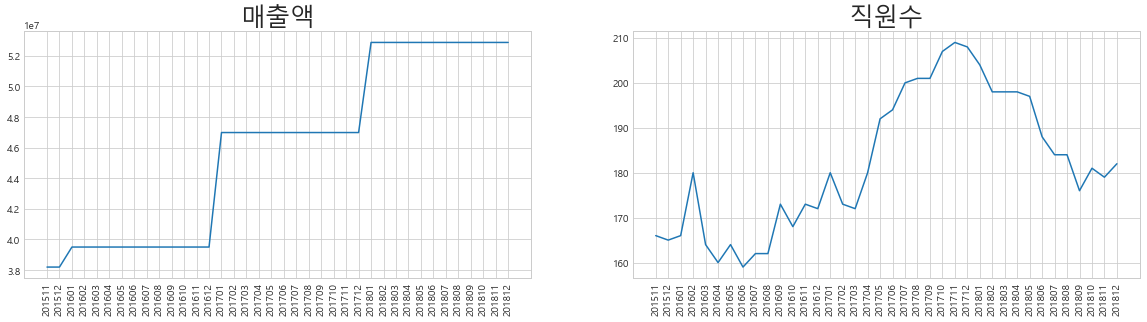



130899 회사 그래프입니다.


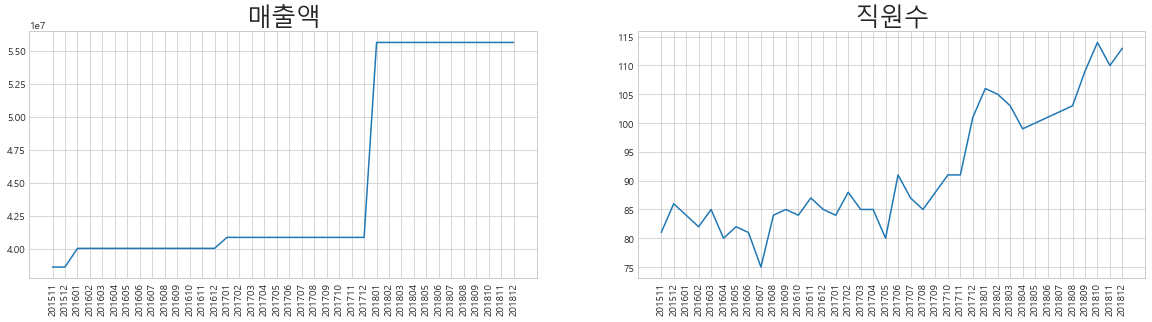



231090 회사 그래프입니다.


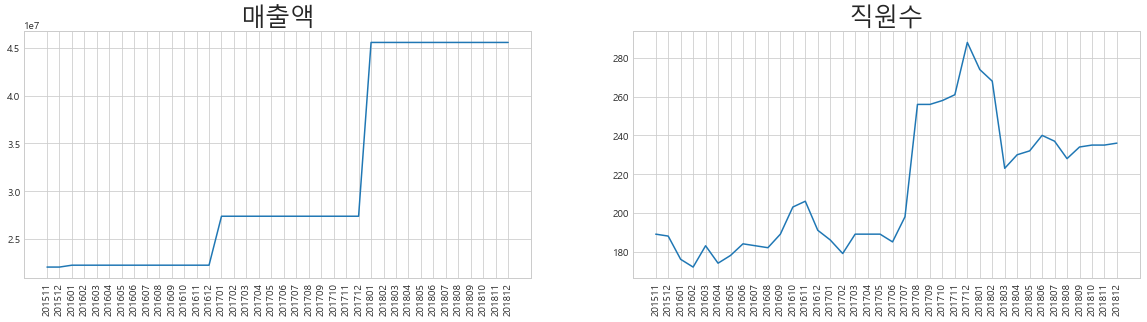



440094 회사 그래프입니다.


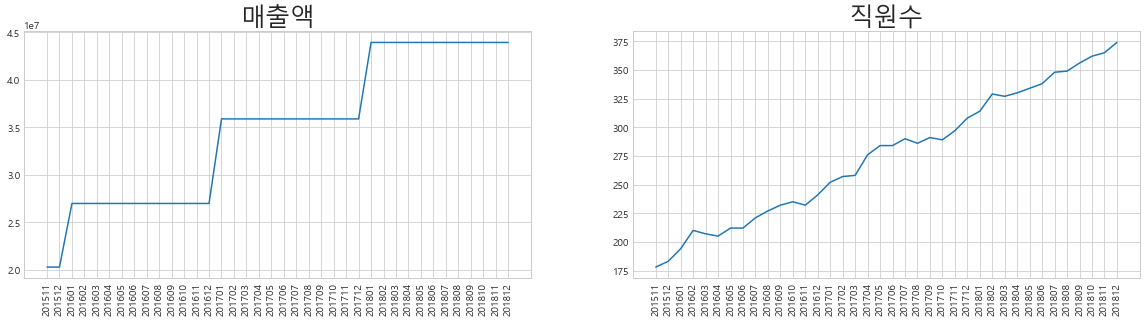

In [24]:
for x in change_worker_list :
    visualization(df,x)

# 확인
- 실제 유니콘 기업의 데이터는 어떠한 형태를 갖는지 확인한다.

## 크롤링을 통하여 시각화를 하기 위한 데이터 수집

In [25]:
# 코드

# 드라이버
driver = webdriver.Chrome('C:/Temp/chromedriver') # 웹드라이버 객체 생성

# 구글을 열어서 키워드 입력 후 이동
driver.get('https://kreditjob.com/') # 구글 홈페이지 내용 렌더링
time.sleep(1)


# 미리 합칠 데이터프레임을 만들어 봅시다.
all_df = pd.DataFrame(columns=['회사ID', '월별_직원수','년월','월별_평균급여'])


# 크롤링을 해봅시다
# 기업 리스트
unicorn = ['우아한형제들', '야놀자', '블랭크코퍼레이션', '뱅크웨어글로벌', '비바리퍼블리카'] 

for name in unicorn :
    
    print(name,"기업 데이터 크롤링을 진행하고 있습니다.")
    
    
    driver.get('https://kreditjob.com/') # 다시 열어줘야만 오류가 안난다...?
    time.sleep(1)
    
    # 검색
    target=driver.find_element_by_css_selector("[class = 'search-query']") # 검색창 설정
    target.send_keys(name) # 검색어 지정
    target.send_keys(Keys.ENTER) # 엔터처리
    time.sleep(4) # 홈페이지가 구성될 때까지 좀 기다려볼까요?


    # 수집할 데이터 컬럼 설정
    name_num = [] # 회사ID
    worker_num = [] # 월별_직원수
    date_num = [] # 년도
    salary_num = [] # 월별_평균급여

    for x in range(2,52):

        # 회사ID는 행마다 넣어줍시다.
        name_num.append(name)

        # 월별_직원수 클릭해서 보기 ==> 5부터 시작 / 55까지 해보자
        data = driver.find_element_by_css_selector('#lineGraph > g:nth-child('+str(x+3)+')')
        data.click()

        # 월별_직원수 가져오기
        try :
            worker_address = '#lineGraph > g.graph-popup'
            worker = driver.find_element_by_css_selector(worker_address)
            worker_text = worker.text
            check = worker_text.split(sep="\n")[1]
            worker_num.append(check)
        except :
            worker_num.append(0)


        # 클릭해서 닫기
        quit = driver.find_element_by_css_selector('#lineGraph > g.graph-popup > g > polygon:nth-child(2)')
        quit.click()

        # 날짜 끌어오기 ==> 2부터 시작 52까지 해보자
        try :
            date_address = '#groupBarGraph > g.axis.xAxis > g:nth-child('+str(x)+')'
            date = driver.find_element_by_css_selector(date_address)
            date_num.append(date.text)
        except :
            date_num.append(0)

    
    # 평균급여 페이지로 넘어가기
    salary_mean_page = driver.find_element_by_css_selector('#root > div > div.body-container > div.company-container > div.company-wrapper > div.company-contents > section.company-monthly-container > div:nth-child(2) > div > div > button.btn.btn.-default')
    salary_mean_page.click()
    
    time.sleep(2) # 렌더링할 시간은 드려야죠.
    
    # for문으로 19년도까지의 데이터를 불러옵니다.
    for y in range(6,56):

        # 평균급여 클릭해보자
        salary_popup = driver.find_element_by_css_selector('#salaryGraph > g:nth-child('+str(y)+')')
        salary_popup.click()

        # 평균급여를 가져와보자
        try :
            salary_address = '#salaryGraph > g.graph-popup'
            salary = driver.find_element_by_css_selector(salary_address)
            salary_total_text = salary.text
            salary_text = salary_total_text.split(sep='\n')[-1]
            salary_num.append(salary_text)
        except :
            salary_num.append(0)

        # 클릭해서 닫기
        quit_again = driver.find_element_by_css_selector('#salaryGraph > g.graph-popup > g > polygon:nth-child(2)')
        quit_again.click()    

    new_df = pd.DataFrame([name_num, worker_num, date_num, salary_num]) # 행 단위로 합쳐진다.
    new_df = new_df.T # 행을 열로 바꾼다
    new_df.columns = ['회사ID', '월별_직원수','년월','월별_평균급여'] # 각 열의 이름을 통합할 데이터프레임의 열과 동일하게 맞춘다.
    all_df = pd.concat([all_df, new_df]) # 각 기업의 데이터를 통합한다.


    driver.back() # 검색창으로 뒤로가기

print("크롤링이 종료되었습니다.")
print()

display(all_df)

우아한형제들 기업 데이터 크롤링을 진행하고 있습니다.
야놀자 기업 데이터 크롤링을 진행하고 있습니다.
블랭크코퍼레이션 기업 데이터 크롤링을 진행하고 있습니다.
뱅크웨어글로벌 기업 데이터 크롤링을 진행하고 있습니다.
비바리퍼블리카 기업 데이터 크롤링을 진행하고 있습니다.
크롤링이 종료되었습니다.



,회사ID,월별_직원수,년월,월별_평균급여
0,우아한형제들,216 명,'15 11월,"2,993,545 원"
1,우아한형제들,221 명,'15 12월,"2,974,596 원"
2,우아한형제들,219 명,'16 1월,"3,097,467 원"
3,우아한형제들,222 명,'16 2월,"2,994,015 원"
4,우아한형제들,226 명,'16 3월,"3,055,818 원"
...,...,...,...,...
45,비바리퍼블리카,264 명,'19 8월,"4,200,937 원"
46,비바리퍼블리카,272 명,'19 9월,"4,250,067 원"
47,비바리퍼블리카,298 명,'19 10월,"4,266,147 원"
48,비바리퍼블리카,310 명,'19 11월,"4,187,554 원"


In [27]:
# 데이터 정제
def cleanText(readData):
    #텍스트에 포함되어 있는 문자 제거
    number = re.sub('[^0-9]', '', readData)
    return number

# 한글 없애기
for x in range(len(all_df)):
    all_df.iloc[x][1] = cleanText(all_df.iloc[x][1])
    all_df.iloc[x][2] = str(20) + cleanText(all_df.iloc[x][2])
    all_df.iloc[x][3] = cleanText(all_df.iloc[x][3])
    
    # 만약 1~9월 사이의 데이터라면?
    if len(all_df.iloc[x][2]) == 5 :
        all_df.iloc[x][2] = all_df.iloc[x][2][:4] + str(0) + all_df.iloc[x][2][4:]
        
# 저장 후 총매출액 추가
all_df.to_excel("./테스트.xlsx")

In [28]:
# 데이터 불러오기
real_df = pd.read_excel("./테스트.xlsx") # 총매출액을 수동으로 추가한 데이터
real_df.drop('Unnamed: 0', axis=1, inplace=True)

# NaN 값 제거
real_df.dropna(axis=0, inplace=True)

# 시계열 통일
real_df['년월'] = pd.to_datetime(real_df['년월'],format='%Y%m').dt.strftime('%Y%m')


# 월별_연금보험료 컬럼 생성
real_df['월별_연금보험료'] = (real_df['월별_직원수'] * real_df['월별_평균급여'] * 0.045).round(0)

# 평균급여 컬럼 drop
real_df = real_df.drop('월별_평균급여', axis=1)

In [29]:
display(real_df)

,회사ID,월별_직원수,년월,연매출액,월별_연금보험료
2,우아한형제들,219,201601,84850263.0,30525537.0
3,우아한형제들,222,201602,84850263.0,29910210.0
4,우아한형제들,226,201603,84850263.0,31077669.0
5,우아한형제들,232,201604,84850263.0,32355001.0
6,우아한형제들,244,201605,84850263.0,33977193.0
...,...,...,...,...,...
245,비바리퍼블리카,264,201908,118730969.0,49907132.0
246,비바리퍼블리카,272,201909,118730969.0,52020820.0
247,비바리퍼블리카,298,201910,118730969.0,57209031.0
248,비바리퍼블리카,310,201911,118730969.0,58416378.0


우아한형제들 회사 그래프입니다.


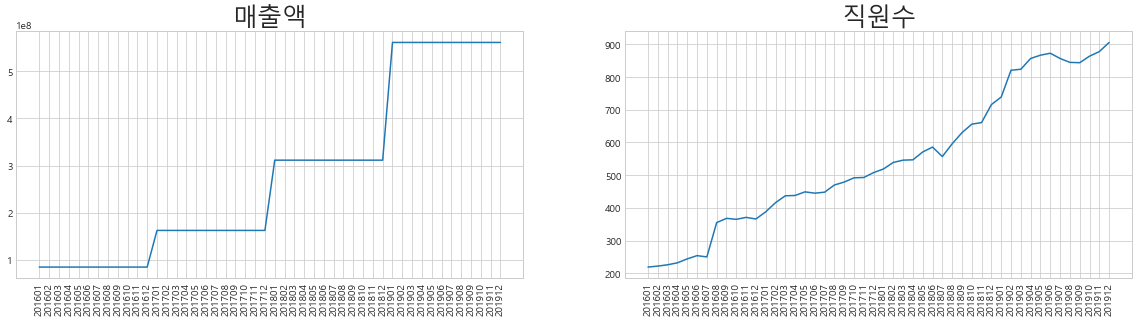



야놀자 회사 그래프입니다.


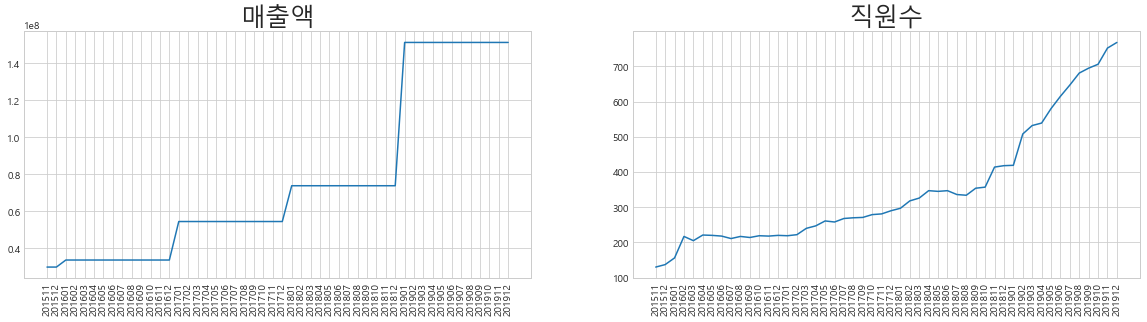



블랭크코퍼레이션 회사 그래프입니다.


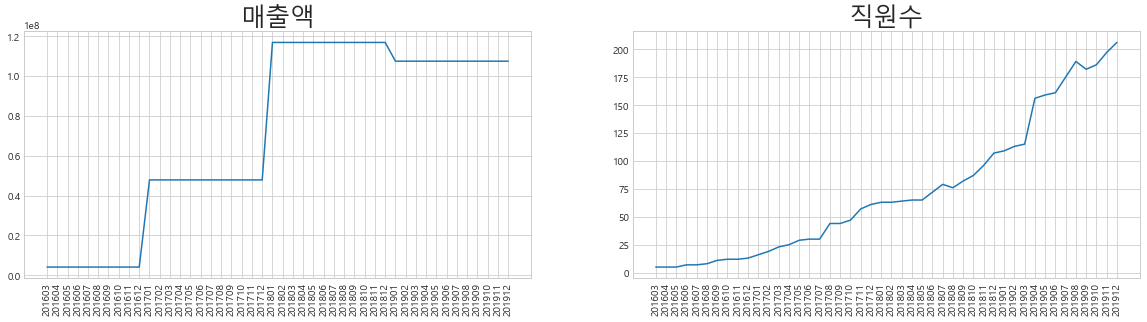



뱅크웨어글로벌 회사 그래프입니다.


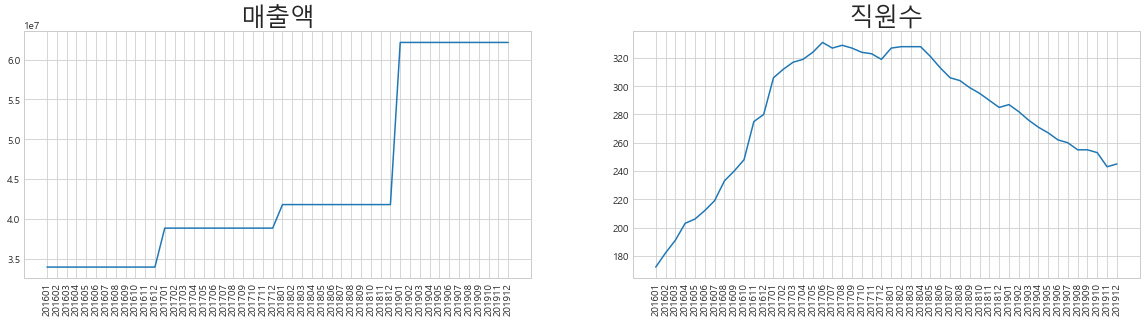



비바리퍼블리카 회사 그래프입니다.


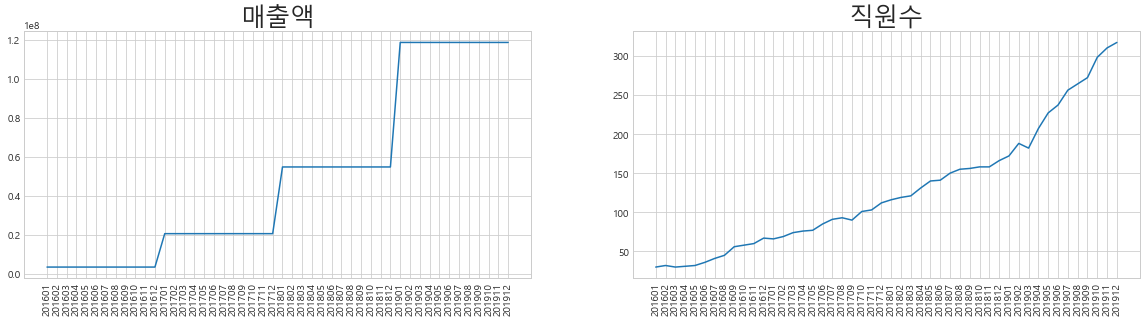

In [33]:
# 시각화 진행
new_list_id = real_df['회사ID'].unique()

for x in new_list_id :
    visualization(real_df,x)

In [13]:
# 실증 데이터는 대체로 우상향하는 그래프
# 원티드 제공 데이터에서 우상향 하는 데이터를 추출

# 선별기업
selected_list = [294387, 294337,231080, 294367, 126538, 403504, 126802, 127503, 127366, 126664, 126983, 227414, 294530, 128264, 227415, 403359, 294649, 127669, 129370, 381344, 469677, 420046, 420304, 130344, 129310, 130387, 129718, 403470, 129861, 128076, 130899, 440094]
print(len(selected_list),"개의 회사가 우상향 그래프를 갖습니다.")

32 개의 회사가 우상향 그래프를 갖습니다.


 # [2차 EDA] 1차 선별기업에 대한 추가작업

![예비유니콘기업조건](./유니콘기업조건.png)

In [14]:
# 원본 데이터 불러오기
df = pd.read_csv('./company_nps_data.csv', encoding='cp949')

In [15]:
# 매출액 증가율 함수
# (공식) 매출액증가율(%) = (당기매출액-전기매출액)/전기매출 *100
def sales_up_rate(company_id):
    temp = df.loc[df['회사ID'] == company_id, :]

    # '회사ID', '년도', '월' 기준으로 오름차순 정렬한 데이터프레임 생성 
    sorted_df = temp.sort_values(by=['회사ID', '년도', '월'], axis=0)
    sorted_df.reset_index(drop=True, inplace=True)

    # 회사 id별로 매출액 증가율 계산 
    sales_rate = sorted_df.drop_duplicates(['연매출액'], keep = 'first')
    sales_rate['매출액증가율'] = 0
    for i in range(1, len(sales_rate)):
        sales_rate['매출액증가율'].iloc[i] = round((sales_rate['연매출액'].iloc[i]-sales_rate['연매출액'].iloc[i-1])
        /sales_rate['연매출액'].iloc[i-1]*100, 4)
    
    # 필요없는 컬럼 정리
    sales_rate.drop(['월', '월별_연금보험료', '월별_직원수'], axis=1, inplace=True)
    
    #최종 데이터 프레임 리턴
    return sales_rate  # 데이터 프레임 리턴 

In [16]:
# 기업별 자료 추출 및 데이터 정렬
def add_ym(company_id):
    com = df.loc[df['회사ID'] == company_id, :]
    com.sort_values(by=['년도', '월'], axis=0, inplace=True)
    com.reset_index(drop=True, inplace=True)

    # 년월 파생변수 만들어주기 
    년월 = com['년도'].map(str) + "-" + com['월'].map(str) #연도와 월 합침
    com.insert(2, '년월',년월)

    # 인당 연금보험료 파생변수 만들어주기(연금보험료/직원수)
    # 국민연금은 급여의 4.5%를 근로자와 사업주가 각각 공제
    인당_연금보험료 = round(com['월별_연금보험료']/com['월별_직원수'], 2)
    com.insert(7, '인당_연금보험료',인당_연금보험료)

    # (파생변수 추가+정렬)된 데이터프레임 리턴
    return com

In [18]:
# 우상향 그래프를 갖는 회사 중 매출액 증가율이 20% 이상인 회사를 찾아봅시다.
for x in selected_list :
    new_df = sales_up_rate(x)
    if sum(new_df['매출액증가율'])/new_df['년도'].nunique() > 20 :
        print(x,"회사의 매출액 증가율 :",sum(new_df['매출액증가율'])/(new_df['년도'].nunique()-1))

294337 회사의 매출액 증가율 : 41.11696666666666
127366 회사의 매출액 증가율 : 62.372166666666665
469677 회사의 매출액 증가율 : 30.630300000000002
403470 회사의 매출액 증가율 : 83.16673333333334
440094 회사의 매출액 증가율 : 29.454800000000002


# 최종 유니콘기업 선정 결과

# 5개의 기업 : 294337 / 127366 / 469677 / 403470 / 440094

# 유니콘기업의 데이터는 어떤 특징을 가질까?



## 1. 연 평균 매출액 증가율이 가장 높은 403470 회사 분석

### (1) 연매출액 & 직원수

In [11]:
# 매출액 증가율 계산 
sales_403470 = sales_up_rate(403470) # 원하는 기업 아이디 입력
sales_403470

,회사ID,연매출액,년도,매출액증가율
0,403470,20264850,2015,0.0000
2,403470,30071287,2016,48.3914
14,403470,84741724,2017,181.8028
26,403470,101101950,2018,19.3060


In [19]:
# 평균 매출 증가율
print('회사ID 403470 연평균 매출 증가율 {}'.format(sum(sales_403470['매출액증가율'])/(sales_403470['년도'].nunique()-1)))

회사ID 403470 연평균 매출 증가율 83.16673333333334


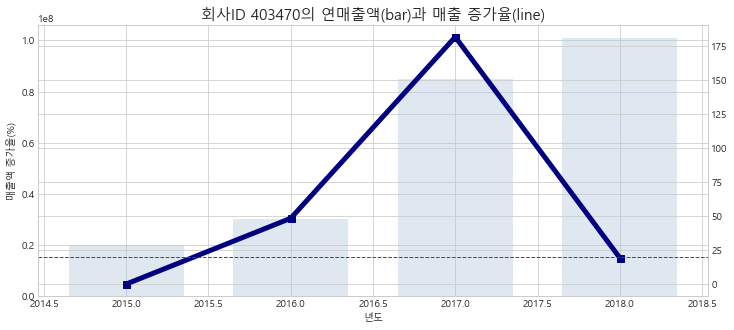

In [78]:
# 연매출액과 매출증가율
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(403470)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 403470" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [79]:
# 403470 기업 자료 추출 및 데이터 정렬
df_403470 = add_ym(403470)
df_403470.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,403470,20264850,2015-11,2015,11,17577140,67,262345.37
1,403470,20264850,2015-12,2015,12,19437000,74,262662.16
2,403470,30071287,2016-1,2016,1,20051960,76,263841.58
3,403470,30071287,2016-2,2016,2,29404660,112,262541.61
4,403470,30071287,2016-3,2016,3,30582300,117,261387.18


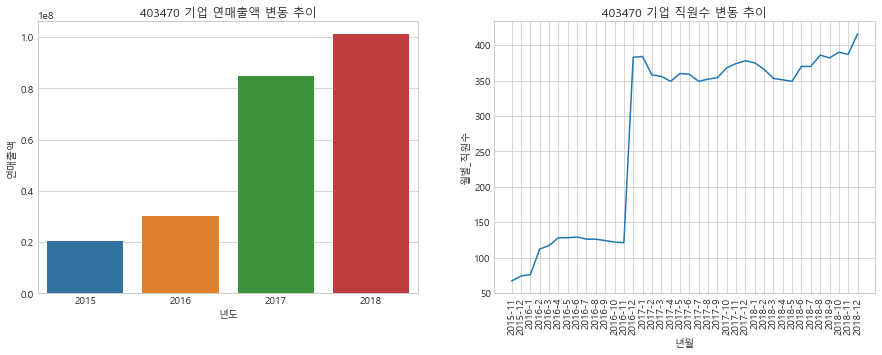

In [80]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_403470['년도'], y=sales_403470['연매출액'])
plt.title('403470 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_403470['년월'], y=df_403470['월별_직원수'])
plt.xticks(rotation=90)
plt.title('403470 기업 직원수 변동 추이')
plt.show()

### (2) 월별_직원수 & 월별_연금보험료

In [81]:
# 년도별 평균값
df_403470.groupby('년도').mean()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,403470.0,20264850.0,11.5,1.850707e+07,70.500000,262503.765000
2016,403470.0,30071287.0,6.5,3.584437e+07,141.000000,258302.593333
2017,403470.0,84741724.0,6.5,9.045188e+07,361.750000,250107.538333
2018,403470.0,101101950.0,6.5,9.765763e+07,374.583333,260570.281667


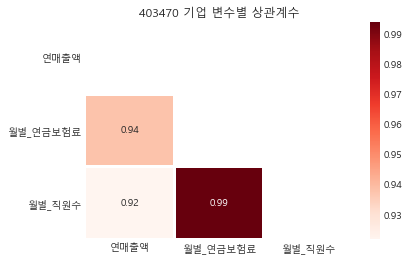

In [82]:
data = df_403470[['연매출액','월별_연금보험료','월별_직원수']]

# Z-score 표준화
for col in data.columns :
    series_mean = data[col].mean()
    series_std = data[col].std() # 가끔 가다 매출액 혹은 직원 변화량이 없어 0으로 찍히기도 한다. ==> 제외해야 함
    data[col] = data[col].apply(lambda x: (x-series_mean)/series_std)

# display(data.head())

# 상관계수 히트맵 
import numpy as np
data = data.corr()
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=data, cmap="Reds", annot=True, mask=mask, fmt=".2f", linewidths=2)
plt.title('403470 기업 변수별 상관계수')
plt.show()

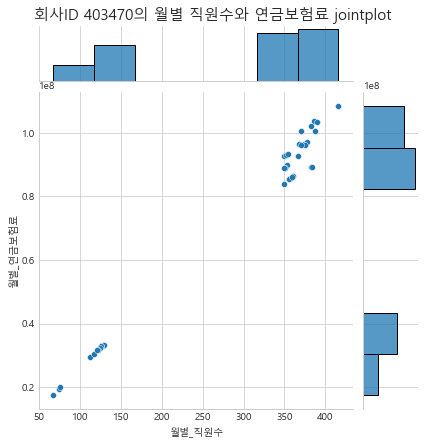

In [83]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_403470['월별_직원수'], y=df_403470['월별_연금보험료'])
plt.suptitle("회사ID " + str(df_403470['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

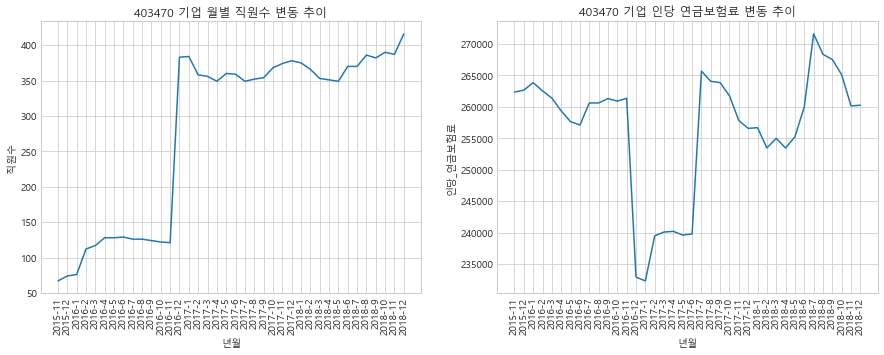

In [84]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_403470['년월'], y=df_403470['월별_직원수'])
plt.xticks(rotation=90)
plt.title('403470 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_403470['년월'], y=df_403470['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('403470 기업 인당 연금보험료 변동 추이')
plt.show()

In [85]:
cor1 = df_403470.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2015,403470.0,20264850.0,11.5,1.850707e+07,70.500000,262503.765000
1,2016,403470.0,30071287.0,6.5,3.584437e+07,141.000000,258302.593333
2,2017,403470.0,84741724.0,6.5,9.045188e+07,361.750000,250107.538333
3,2018,403470.0,101101950.0,6.5,9.765763e+07,374.583333,260570.281667


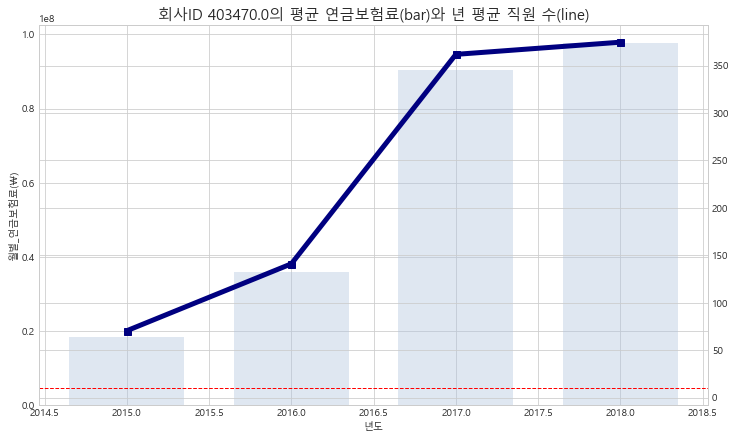

In [86]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()

## 2. 연평균 매출액 증가율이 가장 낮은 440094 회사 분석
### (1) 연매출액 & 직원수

In [20]:
# 매출액 증가율 계산 
sales_440094 = sales_up_rate(440094) # 원하는 기업 아이디 입력
sales_440094

,회사ID,연매출액,년도,매출액증가율
0,440094,20304342,2015,0.0000
2,440094,27000212,2016,32.9775
14,440094,35900640,2017,32.9643
26,440094,43950506,2018,22.4226


In [21]:
# 평균 매출 증가율
print('회사ID 440094 연평균 매출 증가율 {}'.format(sum(sales_440094['매출액증가율'])/(sales_440094['년도'].nunique()-1)))

회사ID 440094 연평균 매출 증가율 29.454800000000002


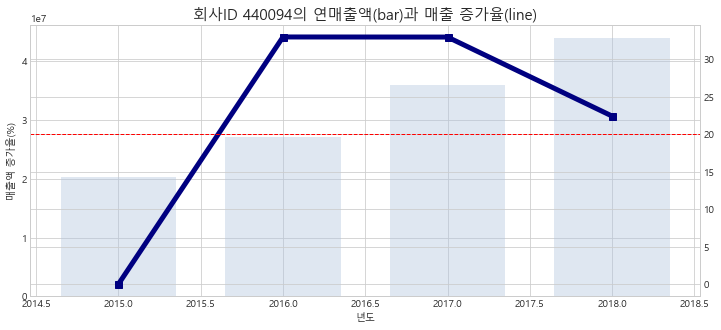

In [89]:
# 연매출액과 매출증가율
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(440094)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 440094" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [90]:
# 440094 기업 자료 추출 및 데이터 정렬
df_440094 = add_ym(440094)
df_440094.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,440094,20304342,2015-11,2015,11,43401700,178,243829.78
1,440094,20304342,2015-12,2015,12,43898980,183,239885.14
2,440094,27000212,2016-1,2016,1,47438920,194,244530.52
3,440094,27000212,2016-2,2016,2,51113320,210,243396.76
4,440094,27000212,2016-3,2016,3,50292900,207,242960.87


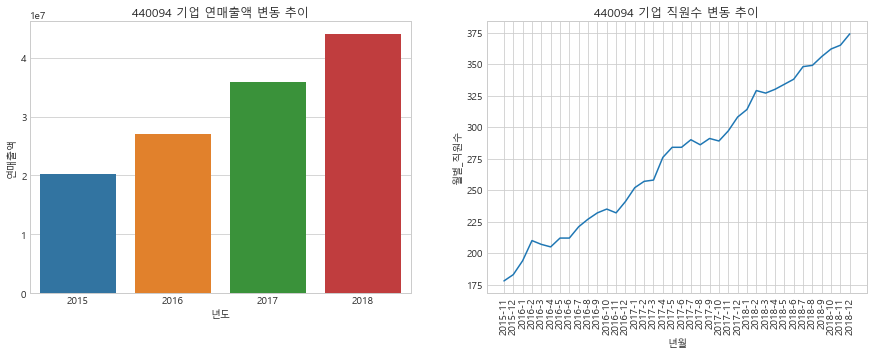

In [91]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_440094['년도'], y=sales_440094['연매출액'])
plt.title('440094 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_440094['년월'], y=df_440094['월별_직원수'])
plt.xticks(rotation=90)
plt.title('440094 기업 직원수 변동 추이')
plt.show()

### (2) 월별_직원수 & 월별_연금보험료

In [92]:
# 년도별 평균값
df_440094.groupby('년도').mean()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,440094.0,20304342.0,11.5,4.365034e+07,180.500000,241857.460000
2016,440094.0,27000212.0,6.5,5.613834e+07,219.000000,255733.998333
2017,440094.0,35900640.0,6.5,7.984482e+07,281.000000,283677.155000
2018,440094.0,43950506.0,6.5,1.031755e+08,343.833333,299611.568333


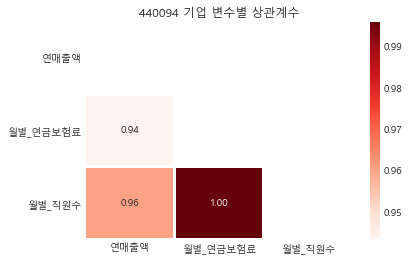

In [93]:
data = df_440094[['연매출액','월별_연금보험료','월별_직원수']]

# Z-score 표준화
for col in data.columns :
    series_mean = data[col].mean()
    series_std = data[col].std() # 가끔 가다 매출액 혹은 직원 변화량이 없어 0으로 찍히기도 한다. ==> 제외해야 함
    data[col] = data[col].apply(lambda x: (x-series_mean)/series_std)

# display(data.head())

# 상관계수 히트맵 
import numpy as np
data = data.corr()
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=data, cmap="Reds", annot=True, mask=mask, fmt=".2f", linewidths=2)
plt.title('440094 기업 변수별 상관계수')
plt.show()

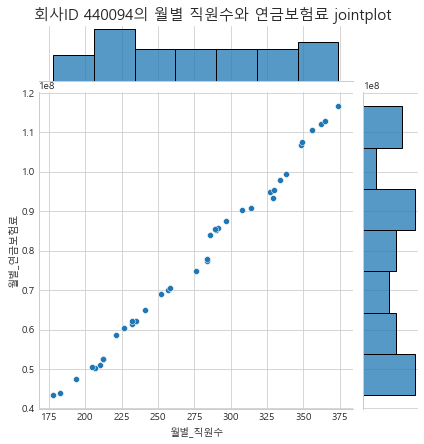

In [94]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_440094['월별_직원수'], y=df_440094['월별_연금보험료'])
plt.suptitle("회사ID " + str(df_440094['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

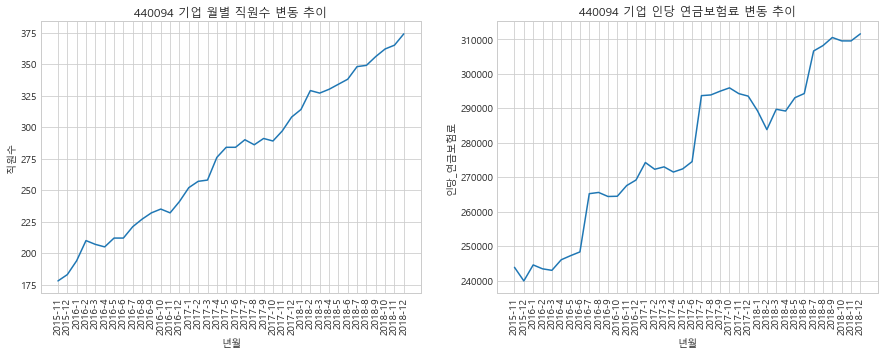

In [95]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_440094['년월'], y=df_440094['월별_직원수'])
plt.xticks(rotation=90)
plt.title('440094 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_440094['년월'], y=df_440094['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('440094 기업 인당 연금보험료 변동 추이')
plt.show()

In [96]:
cor1 = df_440094.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2015,440094.0,20304342.0,11.5,4.365034e+07,180.500000,241857.460000
1,2016,440094.0,27000212.0,6.5,5.613834e+07,219.000000,255733.998333
2,2017,440094.0,35900640.0,6.5,7.984482e+07,281.000000,283677.155000
3,2018,440094.0,43950506.0,6.5,1.031755e+08,343.833333,299611.568333


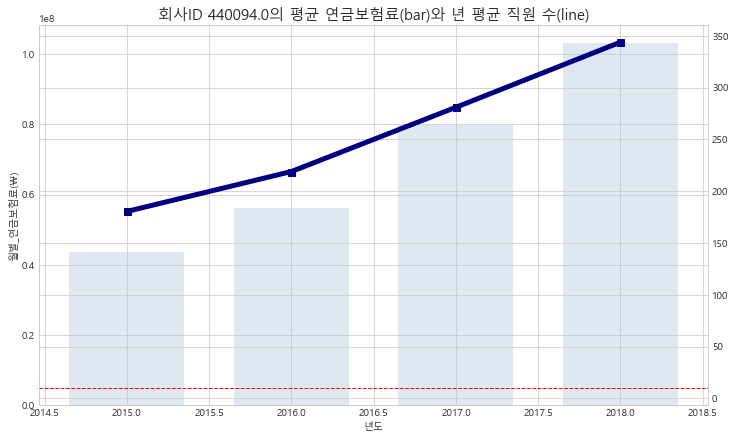

In [97]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()

# 데이터 분석을 통해 얻은 Team1 만의 인사이트
- 유니콘기업의 연매출액과 직원수는 우상향하는 곡선을 그린다.
- 월별_직원수와 월별_연금보험료의 상관관계는 높으나, 반드시 비례하는 것은 아니다.
- 직원수가 급상승한 부분은 투자를 받았던 것으로 판단할 수 있다.


# Team1 유니콘 기업 발굴 결과
# 5개의 기업 : 294337 / 127366 / 469677 / 403470 / 440094

# 끝